In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r'C:\Users\rajas\Documents\GitHub\Post-COVID-Energy-Forecasting\data_set\RE_LONG_FORMAT_2017_2023_WITH_GEO_CLEANED.csv')

df['year'] = df['year'].astype(str).str[-2:].astype(int) + 2000
df['state'] = df['state'].astype(str)
df['generation'] = df['generation'].fillna(0)

In [3]:
df

,year,state,region,latitude,longitude,source,generation
0,2018,Chandigarh,NR,30.7333,76.7794,wind,0.00
1,2018,Delhi,NR,28.7041,77.1025,wind,0.00
2,2018,Haryana,NR,29.0588,76.0856,wind,0.00
3,2018,Himachal Pradesh,NR,31.1048,77.1734,wind,0.00
4,2018,Jammu and Kashmir,NR,33.7782,76.5762,wind,0.00
...,...,...,...,...,...,...,...
1095,2023,Mizoram,NER,23.1645,92.9376,large_hydro,204.13
1096,2023,Nagaland,NER,26.1584,94.5624,large_hydro,177.37
1097,2023,Tripura,NER,23.9408,91.9882,large_hydro,0.00
1098,2023,Dadra and Nagar Haveli,WR,20.1809,73.0169,large_hydro,0.00


In [4]:
train_df = df[df['year'] <= 2022]
test_df = df[df['year'] == 2023]

In [5]:
predictions = []

In [6]:
for (state, source), group in train_df.groupby(['state', 'source']):
    try:
        if group['generation'].sum() == 0:
            print(f"Skipped {state} - {source}: All-zero generation.")
            continue

        group_sorted = group.sort_values('year')
        X_train = pd.DataFrame({'year': group_sorted['year']})
        X_train = sm.add_constant(X_train, has_constant='add')
        y_train = group_sorted['generation']

        model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

        X_test = pd.DataFrame({'year': [2023]})
        X_test = sm.add_constant(X_test, has_constant='add')
        y_pred = model.predict(X_test)[0]

        y_true = test_df[(test_df['state'] == state) & (test_df['source'] == source)]['generation']
        y_true_val = y_true.values[0] if not y_true.empty else np.nan

        predictions.append({
            'state': state,
            'source': source,
            # 'year' : 2023,
            'actual_2023': y_true_val,
            'predicted_2023': y_pred
        })

    except Exception as e:
        print(f"Failed for {state} - {source}: {e}")


Skipped Andaman Nicobar - bio_power: All-zero generation.
Skipped Andaman Nicobar - large_hydro: All-zero generation.
Skipped Andaman Nicobar - wind: All-zero generation.
Skipped Arunachal Pradesh - bio_power: All-zero generation.
Skipped Arunachal Pradesh - wind: All-zero generation.
Skipped Assam - bio_power: All-zero generation.
Skipped Assam - wind: All-zero generation.
Skipped Bihar - large_hydro: All-zero generation.
Skipped Chandigarh - bio_power: All-zero generation.
Skipped Chandigarh - large_hydro: All-zero generation.
Skipped Chandigarh - small_hydro: All-zero generation.
Skipped Chandigarh - wind: All-zero generation.
Skipped Chhattisgarh - wind: All-zero generation.
Skipped Dadra and Nagar Haveli - bio_power: All-zero generation.
Skipped Dadra and Nagar Haveli - large_hydro: All-zero generation.
Skipped Dadra and Nagar Haveli - small_hydro: All-zero generation.
Skipped Dadra and Nagar Haveli - wind: All-zero generation.
Skipped Daman and Diu - large_hydro: All-zero generat

In [7]:
pred_df = pd.DataFrame(predictions).dropna()

In [8]:
mae = mean_absolute_error(pred_df['actual_2023'], pred_df['predicted_2023'])
rmse = mean_squared_error(pred_df['actual_2023'], pred_df['predicted_2023'], squared=False)
mape = (np.abs(pred_df['actual_2023'] - pred_df['predicted_2023']) / pred_df['actual_2023']).mean() * 100

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
pred_df

,state,source,actual_2023,predicted_2023
0,Andaman Nicobar,small_hydro,13.94,7.943997
1,Andaman Nicobar,solar,23.94,20.148561
2,Andhra Pradesh,bio_power,54.86,140.535716
3,Andhra Pradesh,large_hydro,3747.58,2046.617509
4,Andhra Pradesh,small_hydro,410.90,276.010261
...,...,...,...,...
115,Uttarakhand,solar,331.80,240.153962
116,West Bengal,bio_power,0.00,954.861863
117,West Bengal,large_hydro,3423.73,2353.593979
118,West Bengal,small_hydro,204.44,82.213746


In [10]:
pred_df.to_csv("forecast_2023_comparison.csv", index=False)

MAE: 982.10, RMSE: 2631.41, MAPE: inf%


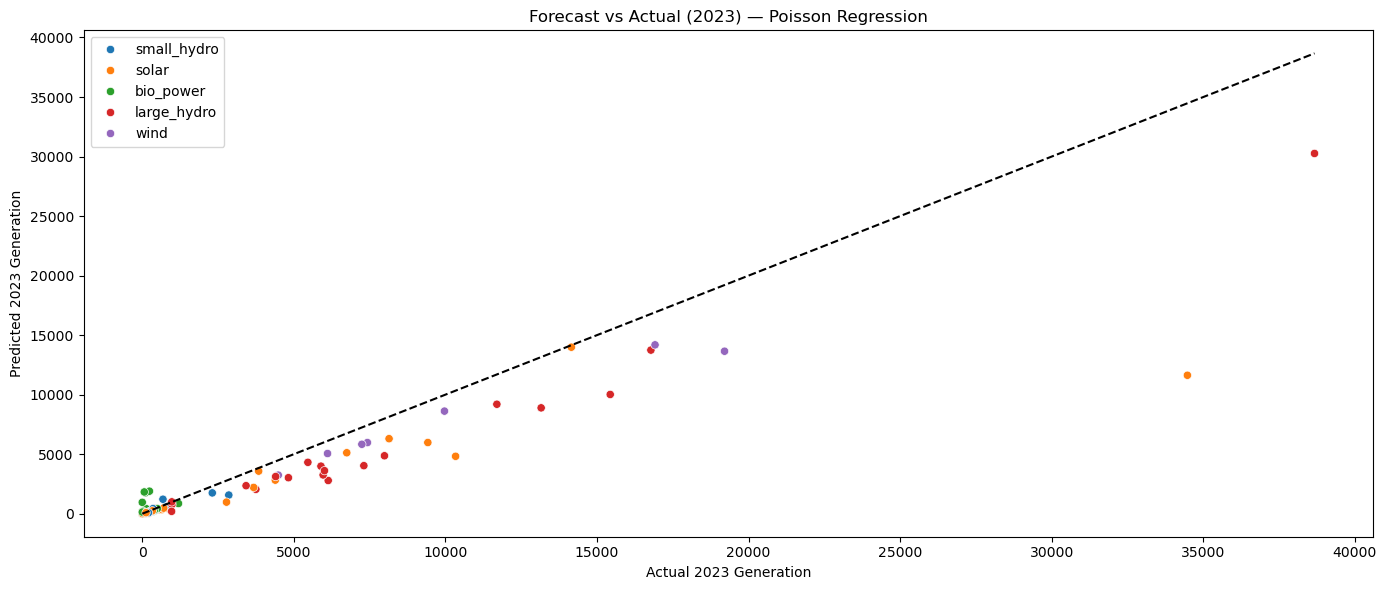

In [11]:
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Visualization
plt.figure(figsize=(14, 6))
sns.scatterplot(data=pred_df, x='actual_2023', y='predicted_2023', hue='source')
plt.plot([pred_df['actual_2023'].min(), pred_df['actual_2023'].max()],
         [pred_df['actual_2023'].min(), pred_df['actual_2023'].max()], 'k--')
plt.title("Forecast vs Actual (2023) — Poisson Regression")
plt.xlabel("Actual 2023 Generation")
plt.ylabel("Predicted 2023 Generation")
plt.legend()
plt.tight_layout()
# plt.savefig("output/forecast_2023_scatter.png")
plt.show()

In [12]:
def safe_mape(y_true, y_pred):
    """MAPE that excludes zero and extreme outliers"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]
    mape = np.abs((y_true - y_pred) / y_true)
    mape = mape[mape < 10]  # Exclude insane outliers >1000%
    return np.mean(mape) * 100

def smape(y_true, y_pred):
    """Symmetric MAPE (handles zero values better)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_val = np.abs(y_true - y_pred) / denominator
    smape_val = smape_val[~np.isnan(smape_val)]  # remove NaNs
    return np.mean(smape_val) * 100

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = safe_mape(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    
    print(f"✅ MAE: {mae:.2f}")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ MAPE (cleaned): {mape_val:.2f}%")
    print(f"✅ SMAPE: {smape_val:.2f}%")

In [13]:
# Merge actual and predicted values to ensure matching rows
merged_df = pd.merge(
    test_df, 
    pred_df, 
    on=['state', 'source'], 
    how='inner', 
    suffixes=('_actual', '_predicted')
)

# Now get aligned values
y_true = merged_df['actual_2023'].values
y_pred = merged_df['predicted_2023'].values  # or 'generation_predicted' based on your column name

# Evaluate
evaluate_model(y_true, y_pred)


✅ MAE: 982.10
✅ RMSE: 2631.41
✅ MAPE (cleaned): 58.89%
✅ SMAPE: 68.33%


In [14]:
r2 = r2_score(y_true, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.8093


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [16]:
pivot_df = df.groupby(['state', 'source'])['generation'].mean().reset_index()
pivot_wide = pivot_df.pivot_table(index='state', columns='source', values='generation', aggfunc='sum',fill_value = 0)


In [17]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(pivot_wide)

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_wide['cluster'] = kmeans.fit_predict(pivot_wide)
final_clusters = pivot_wide.reset_index()[['state', 'cluster']]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
print(final_clusters.columns)


Index(['state', 'cluster'], dtype='object', name='source')


In [20]:
print(final_clusters.sort_values('cluster'))

source                   state  cluster
13            Himachal Pradesh        0
0              Andaman Nicobar        1
19                 Lakshadweep        1
20              Madhya Pradesh        1
22                     Manipur        1
23                   Meghalaya        1
24                     Mizoram        1
35                 Uttarakhand        1
25                    Nagaland        1
27                  Puducherry        1
28                      Punjab        1
30                      Sikkim        1
32                   Telangana        1
33                     Tripura        1
34               Uttar Pradesh        1
26                      Odisha        1
17                      Kerala        1
18                       Ladkh        1
15                   Jharkhand        1
2            Arunachal Pradesh        1
3                        Assam        1
4                        Bihar        1
5                   Chandigarh        1
7       Dadra and Nagar Haveli        1


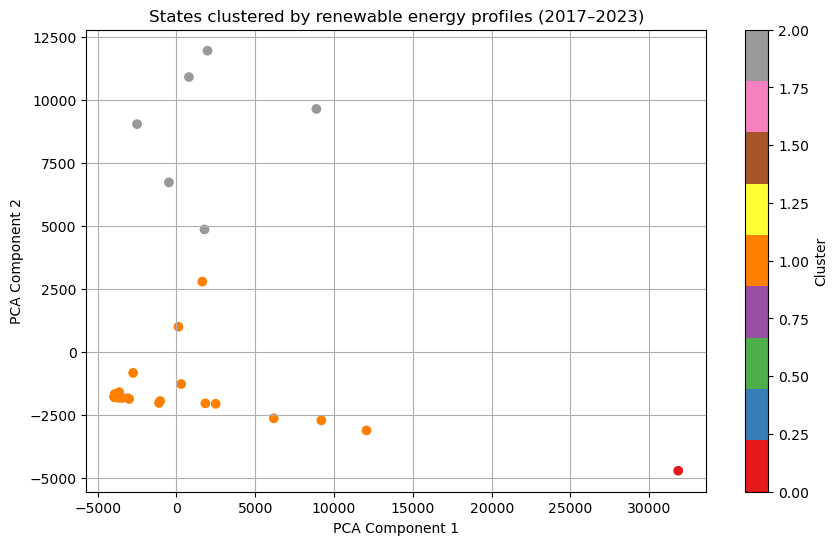

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(pivot_wide.drop('cluster', axis=1))

plt.figure(figsize=(10, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=pivot_wide['cluster'], cmap='Set1')
plt.title("States clustered by renewable energy profiles (2017–2023)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


In [22]:
pivot_wide['cluster'] = kmeans.labels_


In [23]:
cluster_summary = pivot_wide.groupby('cluster').mean()
print(cluster_summary)


source    bio_power   large_hydro  small_hydro        solar         wind
cluster                                                                 
0          0.000000  35820.984000  2077.793333    21.548333     0.000000
1        198.764778   2493.747600   116.853611   446.267878   147.160556
2        872.817500   4756.682333   523.106944  6231.605278  9103.170278


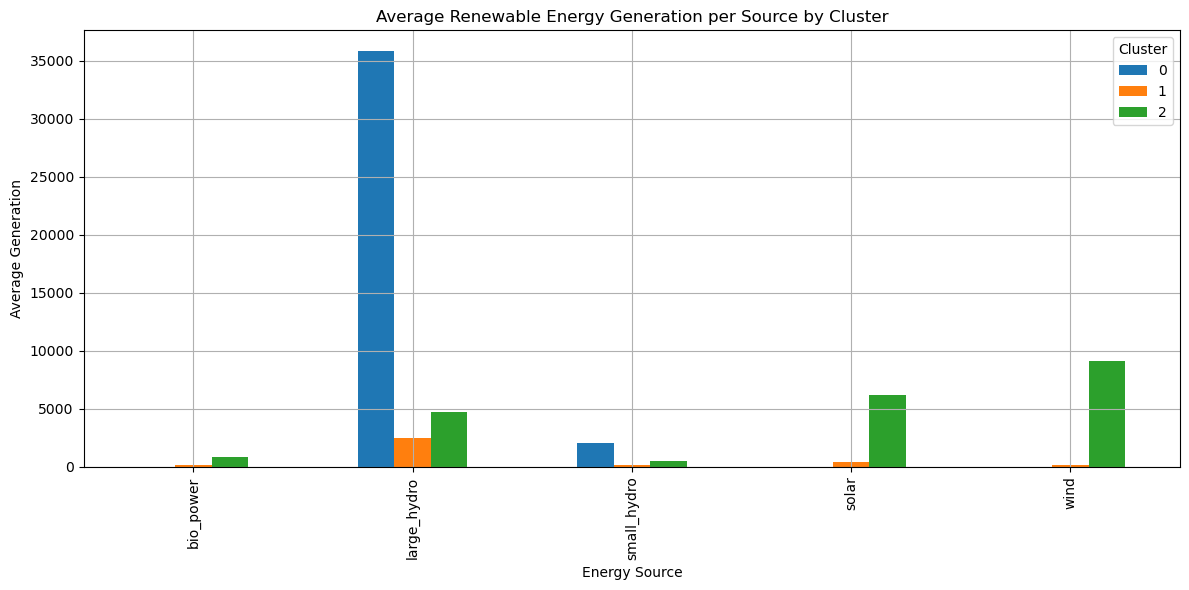

In [24]:
cluster_summary.T.plot(kind='bar', figsize=(12, 6))
plt.title('Average Renewable Energy Generation per Source by Cluster')
plt.xlabel('Energy Source')
plt.ylabel('Average Generation')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


 Strategic Mapping (Qualitative View)
 
Cluster 0 (Hydro-heavy): These are the water-rich, terrain-driven states relying on large-scale hydro projects.

Cluster 1 (Low-gen): Either smaller UTs or states without major renewable projects.

Cluster 2 (Diversified/Modern): Likely states adopting solar/wind aggressively due to policies or terrain (coastal or arid regions).

In [25]:
df_features = pivot_wide[['bio_power', 'large_hydro', 'small_hydro', 'solar', 'wind']]
cluster_labels = pivot_wide['cluster']

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_features)

df_pca = pd.DataFrame(pca_result , columns=['PC1','PC2'])
df_pca['Cluster'] = cluster_labels.values
df_pca['state'] = pivot_wide.index

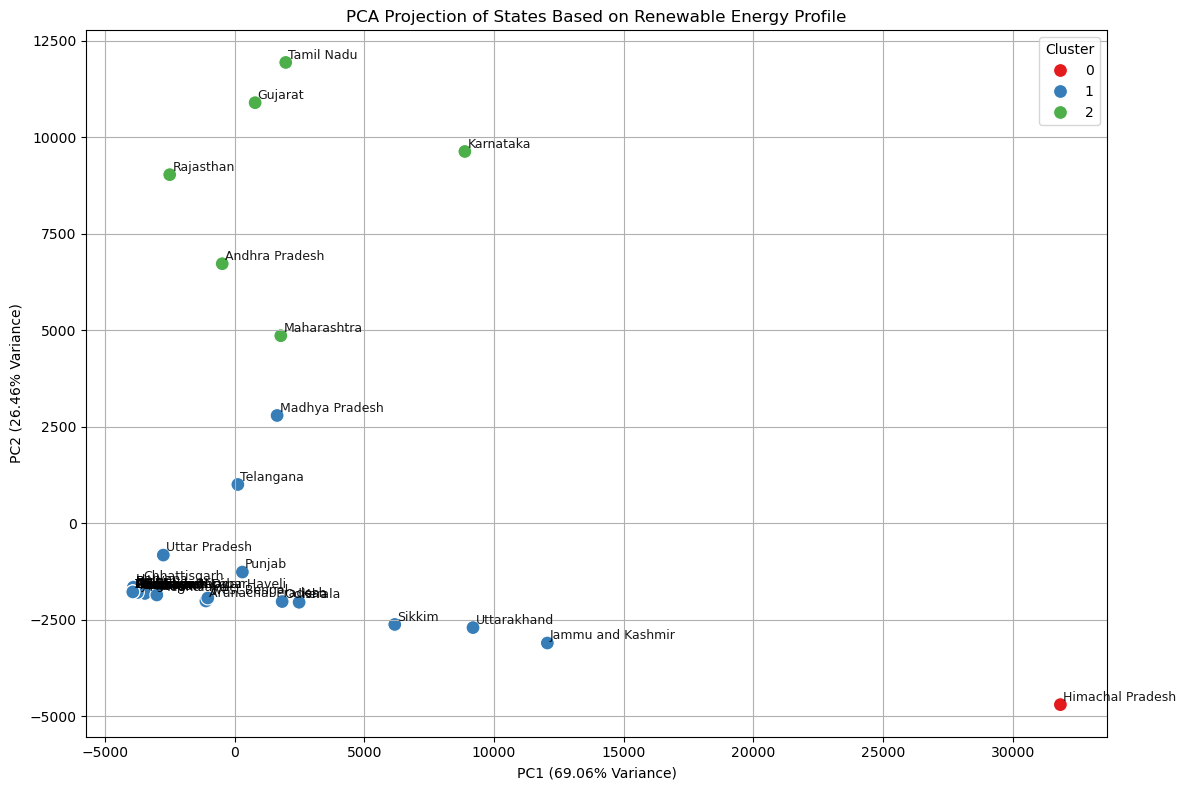

In [27]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=100)

# Add state labels to each point
for i in range(df_pca.shape[0]):
    plt.text(df_pca['PC1'][i] + 100, df_pca['PC2'][i] + 100, df_pca['state'][i], 
             fontsize=9, alpha=0.9)

plt.title('PCA Projection of States Based on Renewable Energy Profile')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)")
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


Himachal Pradesh has a hydro-heavy profile — great, but also imbalanced. This makes it structurally different from other states.

Tamil Nadu, Gujarat, etc. form a well-diversified, high-output cluster — they are your leaders in large-scale renewable implementation across wind, solar, and bio.

The rest (Cluster 1) are still developing, experimenting, or lagging in balanced renewable rollout.

In [28]:
pivot_wide.loc['Himachal Pradesh']


source
bio_power          0.000000
large_hydro    35820.984000
small_hydro     2077.793333
solar             21.548333
wind               0.000000
cluster            0.000000
Name: Himachal Pradesh, dtype: float64